<a href="https://colab.research.google.com/github/hawkeyedatatsai/Airline-Customer-Satisfication/blob/main/custom_classification_metric_function_on_Airline_Customer_Satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.compose import make_column_selector
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error \
                            , mean_absolute_percentage_error

#modeling
from tensorflow import keras
from keras import Sequential, metrics
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, \
classification_report, ConfusionMatrixDisplay, f1_score

2023-05-09 16:09:08.268749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#custom function  to plot our model's learning history
# Learning history plotting function
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [ ]:
def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""
  
    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, )

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

#Problem
An airline company would like to know more about their customers and how to please them. They have provided some information about 20,000 customers as well as the results of a satisfaction survey. The data is available [here](https://docs.google.com/spreadsheets/d/e/2PACX-1vSAUJiI10coRG2ZgJ_H6PJkPuIfr-tYVRRX9wtJvAyI_SHnAjvbd7RZHifP6XoeSS9HPNp38IfzPzIY/pub?output=csv).

They would like you to:

1. Segment the customers into groups and describe those groups, what they have in common and how they differ.

2. Model the data to see if overall customer satisfaction can be predicted by information about their flights and answers to the survey other than overall satisfaction.

#Clustering Instructions:

The airline company would like you to segment the customers and create an analytical report on the clusters describing each group and describing how they are different.

1. Load the dataset.

2. Explore the data.

3. Prepare the data for modeling.

4. Use a KMeans model to cluster the passengers into an optimal number of clusters.

Use an elbow plot and silhouette score to find the optimal number of clusters.
There must be between 2 and 10 clusters.
5. Analyze and report on the clusters.

Describe each cluster.
How are the clusters different?
Create 2 report quality explanatory visualizations showing important differences between the clusters.
Interpret and explain each visualization.

In [ ]:
df = pd.read_csv('flight_df - flight_df.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                20000 non-null  int64
 1   Class                              20000 non-null  int64
 2   Flight Distance                    20000 non-null  int64
 3   Inflight wifi service              20000 non-null  int64
 4   Departure/Arrival time convenient  20000 non-null  int64
 5   Ease of Online booking             20000 non-null  int64
 6   Gate location                      20000 non-null  int64
 7   Food and drink                     20000 non-null  int64
 8   Online boarding                    20000 non-null  int64
 9   Seat comfort                       20000 non-null  int64
 10  Inflight entertainment             20000 non-null  int64
 11  On-board service                   20000 non-null  int64
 12  Leg room service  

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
0,26,3,2062,2,3,3,3,2,2,2,...,3,3,3,2,0,0,0,1,1,0
1,52,3,680,5,5,5,5,3,4,4,...,4,4,4,4,18,2,0,1,1,1
2,28,1,188,3,5,3,4,3,3,3,...,4,4,5,3,0,0,1,1,0,0
3,54,3,453,3,5,5,5,3,4,4,...,3,4,3,1,91,80,0,1,1,0
4,40,1,775,4,3,3,3,4,4,4,...,3,3,3,4,0,0,1,1,1,0


In [ ]:
df.describe()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,39.477250,2.027800,1188.548000,2.727950,3.056100,2.751100,2.971350,3.202100,3.255300,3.439100,...,3.623650,3.302850,3.635550,3.282650,14.318350,14.698250,0.490650,0.817850,0.687900,0.43305
std,15.108901,0.963054,1001.136957,1.326886,1.531134,1.396799,1.279575,1.332383,1.348485,1.323434,...,1.186837,1.259131,1.184017,1.311734,36.451829,36.899857,0.499925,0.385978,0.463362,0.49551
min,7.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,27.000000,1.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
50%,40.000000,2.000000,842.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000
75%,51.000000,3.000000,1733.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,...,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000,1.000000,1.000000,1.00000
max,85.000000,3.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,1305.000000,1280.000000,1.000000,1.000000,1.000000,1.00000


In [ ]:
# explore data
for col in df.columns:
  print(col)
  print(df[col].value_counts())
  print()

Age
39    551
25    504
40    502
42    497
44    478
     ... 
78      6
73      5
79      4
85      3
76      3
Name: Age, Length: 75, dtype: int64

Class
3    9560
1    9004
2    1436
Name: Class, dtype: int64

Flight Distance
337     144
404      88
2475     81
862      78
594      78
       ... 
1573      1
875       1
1963      1
3584      1
1515      1
Name: Flight Distance, Length: 3108, dtype: int64

Inflight wifi service
3    4992
2    4969
4    3778
1    3468
5    2213
0     580
Name: Inflight wifi service, dtype: int64

Departure/Arrival time convenient
4    4844
5    4348
3    3490
2    3265
1    3006
0    1047
Name: Departure/Arrival time convenient, dtype: int64

Ease of Online booking
3    4731
2    4637
4    3729
1    3399
5    2648
0     856
Name: Ease of Online booking, dtype: int64

Gate location
3    5547
4    4619
2    3733
1    3414
5    2686
0       1
Name: Gate location, dtype: int64

Food and drink
4    4691
5    4306
3    4298
2    4165
1    2524
0      16
Na

In [ ]:
#check duplicates
df.drop_duplicates(inplace = True)
df.duplicated().sum()

0

In [ ]:
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
scaled_df = scaler.fit_transform(df)

#4. Use a KMeans model to cluster the passengers into an optimal number of clusters.


Text(0, 0.5, 'inertia')

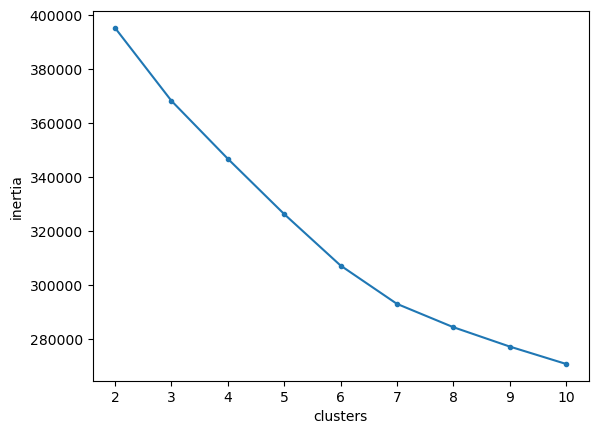

In [ ]:
#cluster-elbow plot
#Create an empty list of inertias
inertias = []
#Loop through k values between 2 and 10 and store the inertias in the list.
for k in range(2,11):
    kmeans = KMeans(n_clusters=k)  
    kmeans.fit(scaled_df)  
    inertias.append(kmeans.inertia_)
#Visualize scores
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('clusters')
plt.ylabel('inertia')

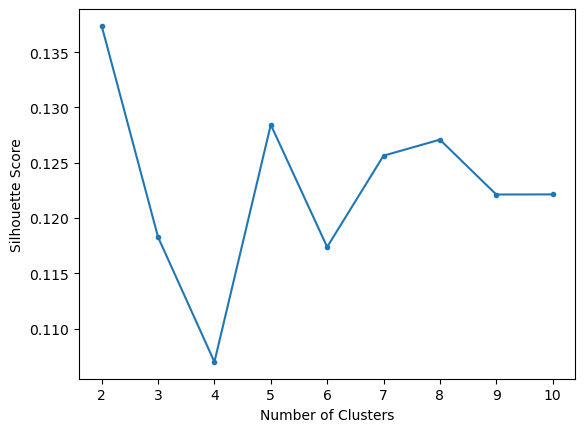

In [ ]:
#cluster- silhouette score
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(scaled_df)
  silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))
# Visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

Elbow Plot suggest when the # of cluster can be either 6 or 7.

From silhouette scores, since higher silhouette score is preferred, I would sugegst 2 clusters is the decision.

##Cluster=2

In [ ]:
kmeans2 = KMeans(n_clusters = 2)
kmeans2.fit(scaled_df)
#Save the cluster labels to the dataframe 
df['cluster2'] = kmeans2.labels_
df.head()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied,cluster2
0,26,3,2062,2,3,3,3,2,2,2,...,3,3,2,0,0,0,1,1,0,1
1,52,3,680,5,5,5,5,3,4,4,...,4,4,4,18,2,0,1,1,1,0
2,28,1,188,3,5,3,4,3,3,3,...,4,5,3,0,0,1,1,0,0,1
3,54,3,453,3,5,5,5,3,4,4,...,4,3,1,91,80,0,1,1,0,1
4,40,1,775,4,3,3,3,4,4,4,...,3,3,4,0,0,1,1,1,0,1


In [ ]:
#analyzing clusters
cluster_groups = df.groupby('cluster2', as_index=False).mean()
cluster_groups

,cluster2,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
0,0,42.165845,2.537299,1521.029576,3.235513,3.107241,3.106255,3.011721,3.782232,4.063862,...,4.093110,3.691752,4.099354,3.983897,12.581334,12.668529,0.506408,0.890349,0.871618,0.822982
1,1,37.219483,1.599945,909.344219,2.301720,3.013154,2.452856,2.937448,2.714930,2.576304,...,3.229418,2.976267,3.246068,2.693772,15.777021,16.402723,0.477417,0.756968,0.533622,0.105602


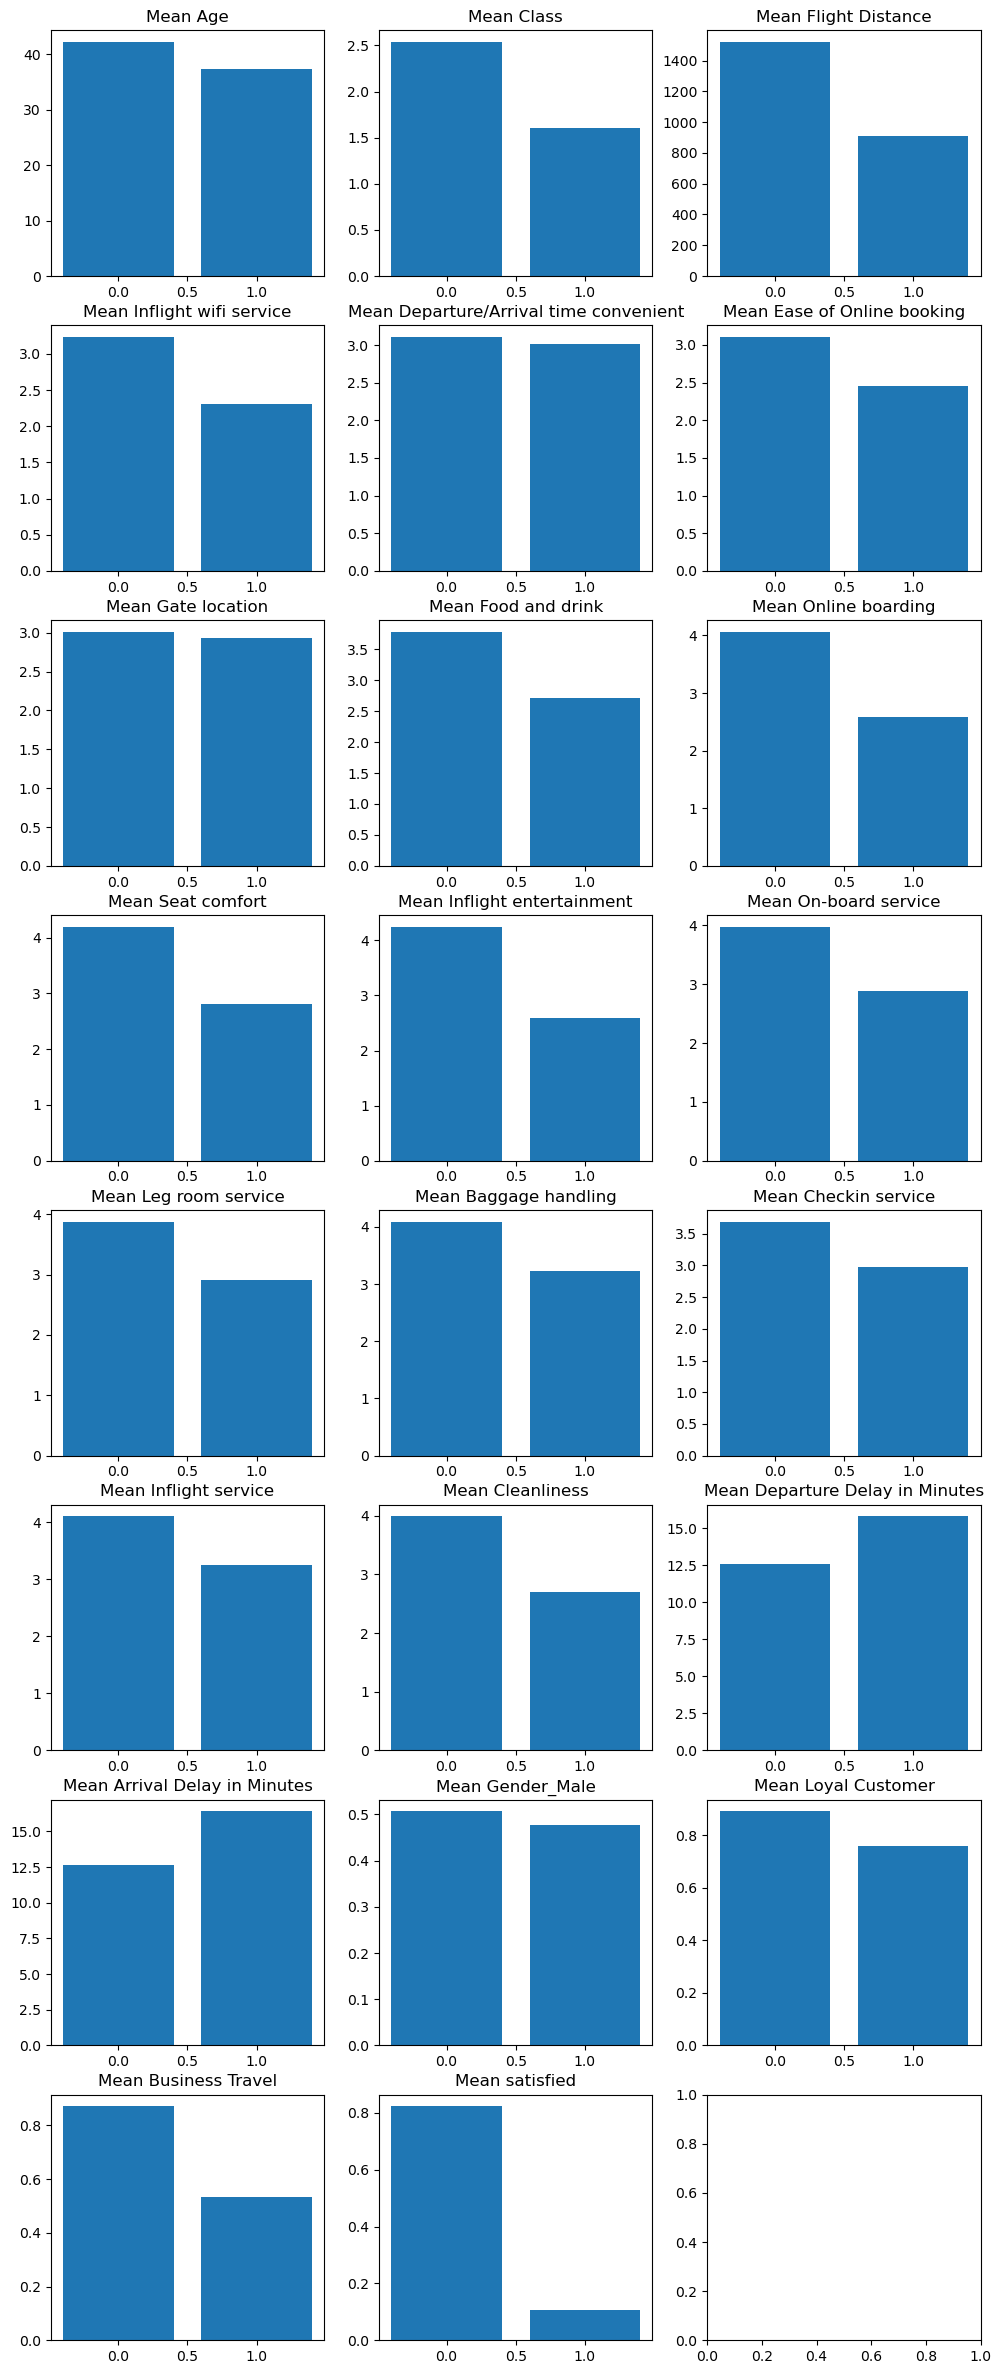

In [ ]:
#Visualize means 
fig, axes = plt.subplots(8,3, figsize = (12, 30))
axes = axes.ravel()

for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster2'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

#Analyze and report clusters

After studies above, the dypte of data is observed as below.

1. numercial cols:
- Age
- Flight Distance
- Departure Delay in Minutes
- Arrival Delay in Minutes

2. nominal cols: the rest 

<AxesSubplot: >

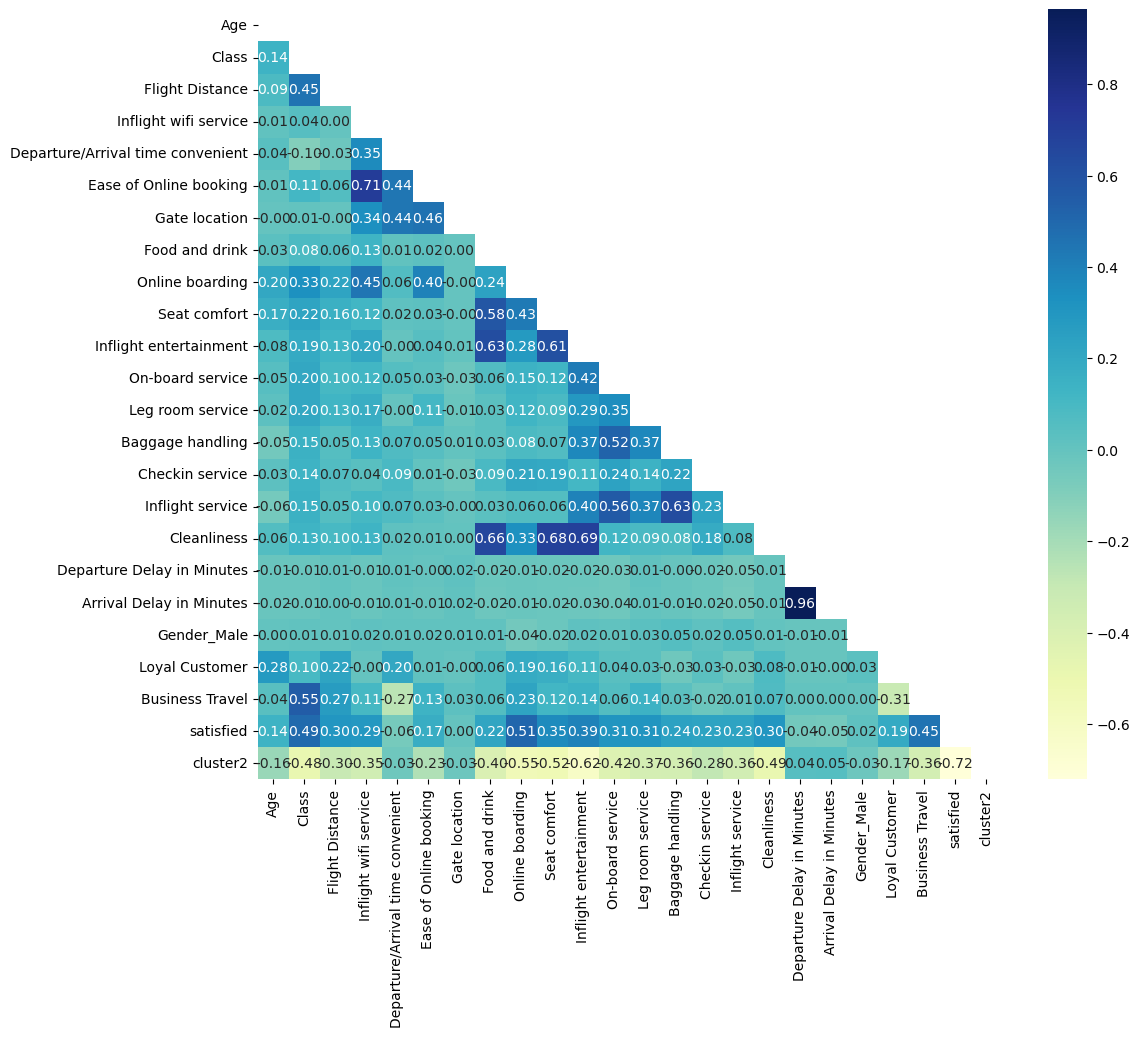

In [ ]:
# Correlation Heatmap
corr = df.corr()
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt='.2f', mask=mask, ax=ax)

Text(0, 0.5, 'Departure Delay in Minutes')

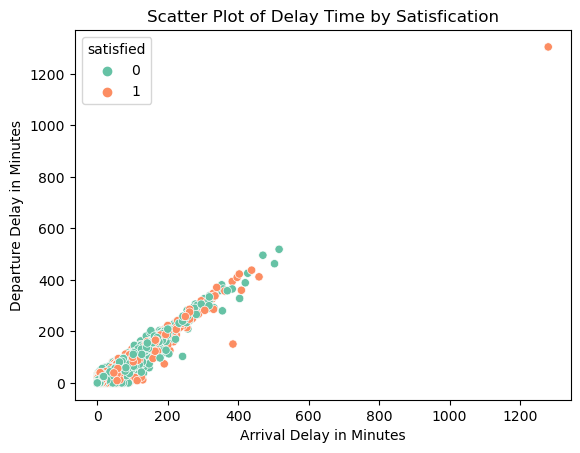

In [ ]:
sns.scatterplot(y ='Departure Delay in Minutes', x = 'Arrival Delay in Minutes', data = df, hue = 'satisfied', palette='Set2')
plt.title('Scatter Plot of Delay Time by Satisfication')
plt.xlabel('Arrival Delay in Minutes')
plt.ylabel('Departure Delay in Minutes')

Text(0, 0.5, 'Departure  Delay in Minutes')

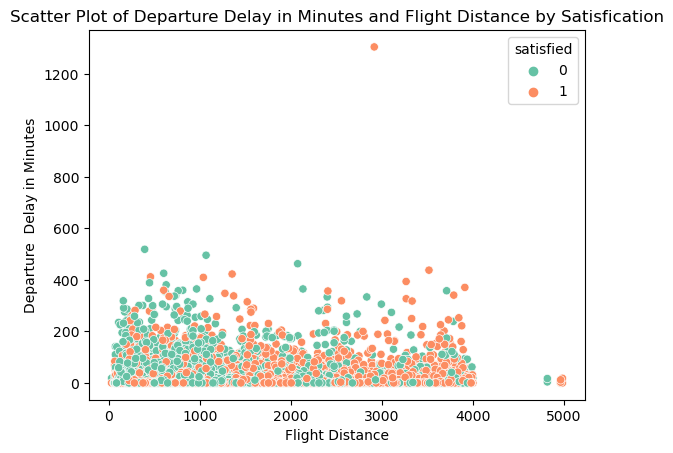

In [ ]:
sns.scatterplot(y ='Departure Delay in Minutes', x = 'Flight Distance', data = df, hue = 'satisfied', palette='Set2')
plt.title('Scatter Plot of Departure Delay in Minutes and Flight Distance by Satisfication')
plt.xlabel('Flight Distance')
plt.ylabel('Departure  Delay in Minutes')

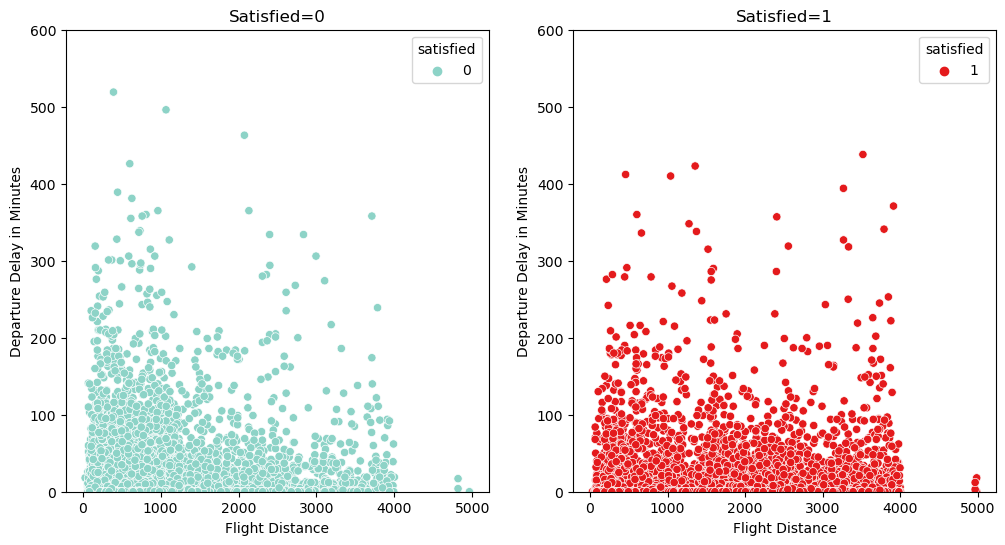

In [ ]:
#dataframes for satisfied=0 and 1 individually
df_satisfied_0 = df[df['satisfied'] == 0]
df_satisfied_1 = df[df['satisfied'] == 1]

#set up the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

#scatterplot for satisfied=0
sns.scatterplot(ax=ax1, y ='Departure Delay in Minutes', x = 'Flight Distance', 
                data=df_satisfied_0, hue='satisfied', palette='Set3')
ax1.set_title('Satisfied=0')

#scatterplot for satisfied=1
sns.scatterplot(ax=ax2, y ='Departure Delay in Minutes', x = 'Flight Distance', 
                data=df_satisfied_1, hue='satisfied', palette='Set1')
ax2.set_title('Satisfied=1')

#set y-limits for both plots to be the same scale
ax1.set_ylim(0, 600)
ax2.set_ylim(0, 600)

plt.show()

Text(0, 0.5, 'Frequency')

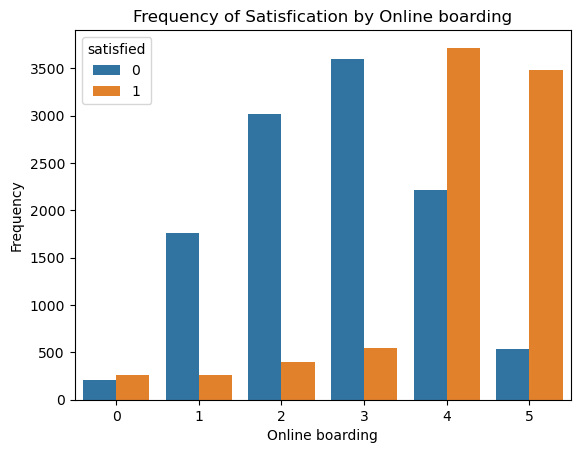

In [ ]:
sns.countplot(x='Online boarding', hue='satisfied', data=df)

plt.title('Frequency of Satisfication by Online boarding')
plt.xlabel('Online boarding')
plt.ylabel('Frequency')

#Modeling Instructions

The airline would also like to know how well overall satisfaction can be predicted from information about passengers and satisfaction with specific parts of their experience. Your target will be the 'satisfied' column.

1. Use random_state = 42 for your train_test_split
2. Use PCA to prepare the data for modeling.
  - Reduce the number of features in the data
  - Be sure to use the PCA-transformed data when you fit and validate your predictive model.
3. Do not leak data while preparing your data for modeling.
4. Use a deep learning model to predict which students will pass and which will fail
  1. Use the PCA-transformed data you created in Step 2.
  2. Create 3 different versions of a sequential model.
    1. Each new model should be an iteration of the previous model.
    2. Justify in writing why you changed what you did for each new model. (For example, why did you add layers, regularization, nodes, etc)
    3. Adding or reducing epochs does not count as a new model.
  3. Use some form of regularization with at least one model.
  4. Evaluate each model with multiple appropriate metrics.
5. Choose a final model and justify your choice.
6. Evaluate your final model with multiple metrics.
7. Based on those metrics, explain in writing how well your model will solve the business problem.

/var/folders/dj/tq7kx_ys6m161zqrzvh_73q80000gn/T/ipykernel_5007/2049694065.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


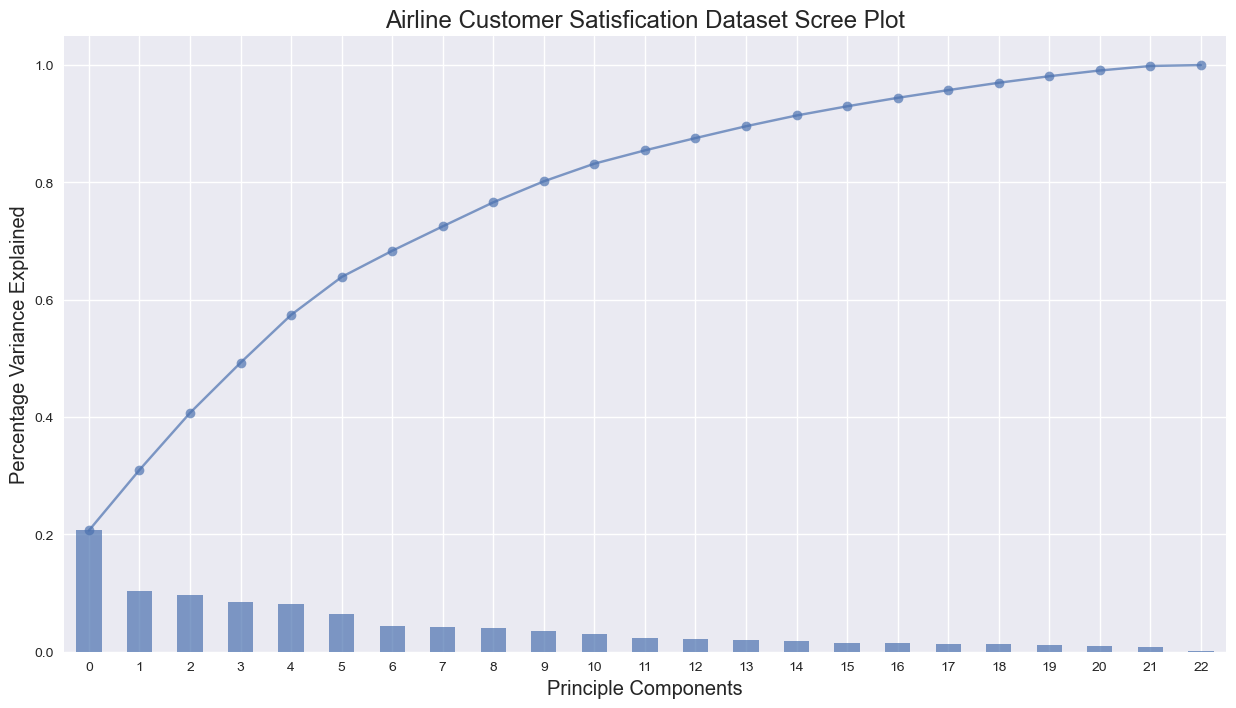

In [ ]:
y = df['satisfied']
X = df.drop(columns=['satisfied'])

scaler = StandardScaler()
# Fit & transform data.
scaled_df = scaler.fit_transform(X)
pca = PCA()
pca.fit(scaled_df)
# Lets visual the cummulative sum of the variances 

plt.style.use("seaborn")
plt.figure(figsize=(15,8))
exp_var = pd.Series(pca.explained_variance_ratio_)

# Plot the variance for each component
exp_var.plot(kind="bar", alpha=0.7) # plot bar chart

# Calculate the amount of variance explained added by each additional component
total = 0
var_ls = []
for x in exp_var:
    total = total+x
    var_ls.append(total)
    
# Plot line chart of increasing variances
pd.Series(var_ls).plot(marker="o", alpha=0.7) 

# Plot labels and titles
plt.xlabel("Principle Components", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Airline Customer Satisfication Dataset Scree Plot", fontsize="xx-large")
plt.show();

decide to select principle components = 13, that means im only going to use 56.5% (13/23) of features and still get around 90% of variance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
# Instantiate Standard Scaler
scaler = StandardScaler()

# Fit & transform data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit PCA
pca = PCA(n_components= 13)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

##Deep Learning Models

###Model 1

2 layers, 50% drop number of neurons per layer, without regularization.

2023-05-09 16:10:01.107871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


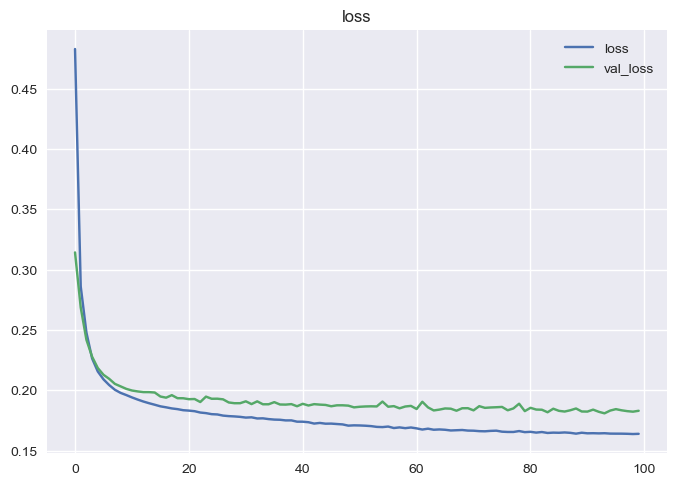

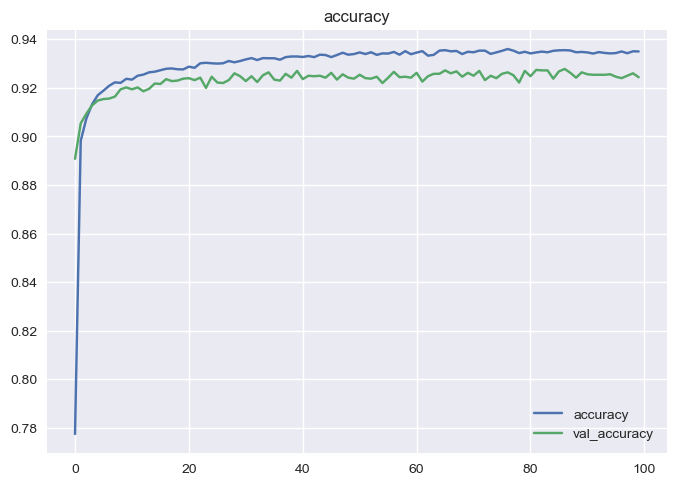

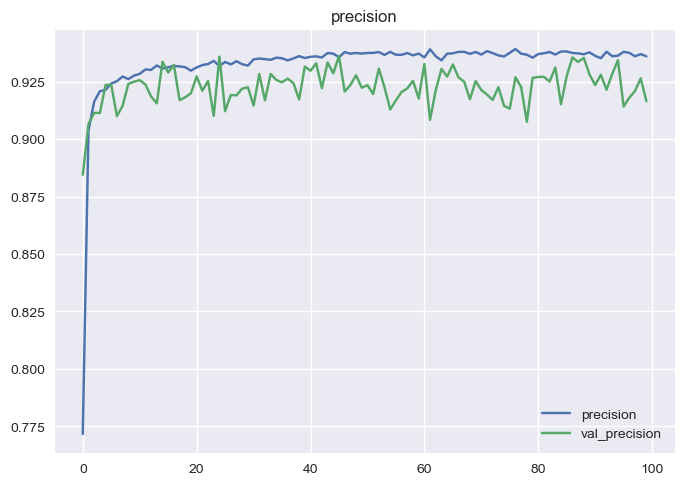

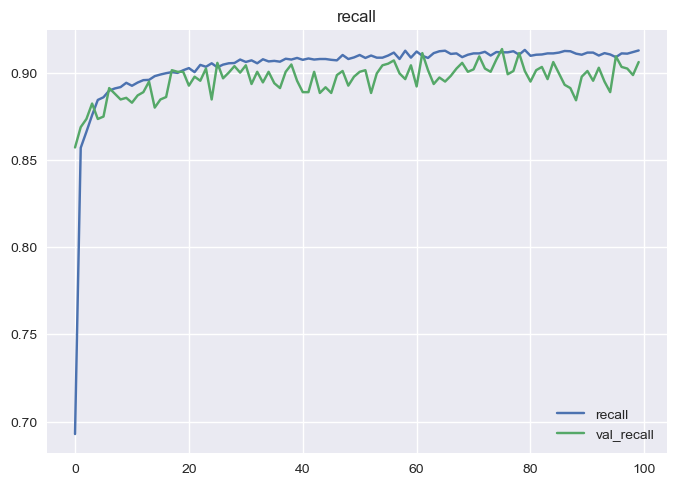

In [ ]:
#create model architecture
input_shape = X_train.shape[1]
 
class_model1 = Sequential()

#Hidden layers
class_model1.add(Dense(input_shape, input_dim=input_shape, activation='relu'))
class_model1.add(Dense(input_shape * 0.5, activation='relu'))
#Output layer
class_model1.add(Dense(1, activation='sigmoid'))
#compile model with additional metrics
class_model1.compile(loss='bce', optimizer='adam', metrics=['accuracy',
                                                         metrics.Precision(),
                                                         metrics.Recall()])
history1 = class_model1.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs=100,
                        verbose=0)
# plot learning
plot_history(history1)

157/157 [==============================] - 0s 826us/step
base_class_model1_train 

              precision    recall  f1-score   support

 Unsatisfied       0.94      0.95      0.94      8482
   Satisfied       0.93      0.92      0.92      6518

    accuracy                           0.94     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.94      0.93     15000



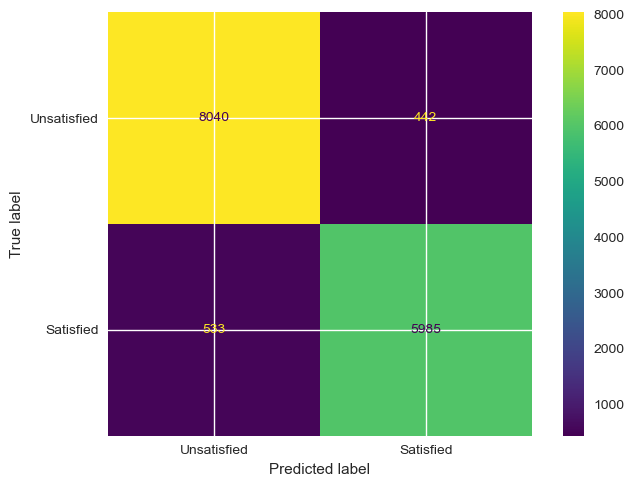

base_class_model1_test 

              precision    recall  f1-score   support

 Unsatisfied       0.93      0.94      0.93      2857
   Satisfied       0.92      0.91      0.91      2143

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



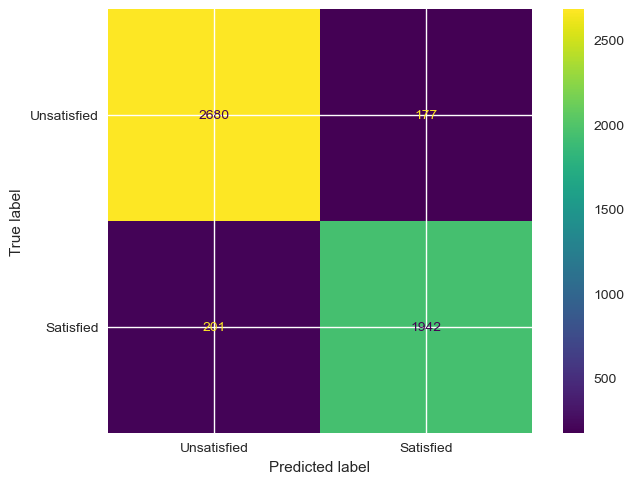

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
base_class_model1_train,0.931228,0.918226,0.924681,0.9350
base_class_model1_test,0.916470,0.906206,0.911309,0.9244


In [ ]:
# Get predictions
model1_train_pred = class_model1.predict(X_train)
model1_test_pred = class_model1.predict(X_test)

# round predictions to integers instead of floats using np.rint()
model1_train_preds = np.rint(model1_train_pred )
model1_test_preds = np.rint(model1_test_pred )

# Define labels for the confusion matrix
labels = ['Unsatisfied', 'Satisfied']
train_scores = eval_classification(y_train, model1_train_preds, 
                                   name='base_class_model1_train',
                                  labels=labels)
test_scores = eval_classification(y_test, model1_test_preds, 
                                   name='base_class_model1_test',
                                  labels=labels)
class_scores = pd.concat([train_scores, test_scores])
class_scores

Since there is an obvious overfitting, decide to try regularizations include both early stopping and dropout

###Model 2

is composed of Model 1 with regularization (Early Stopping)

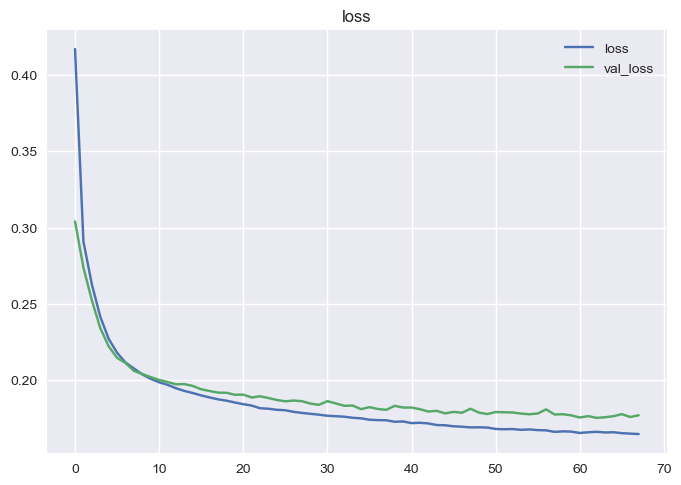

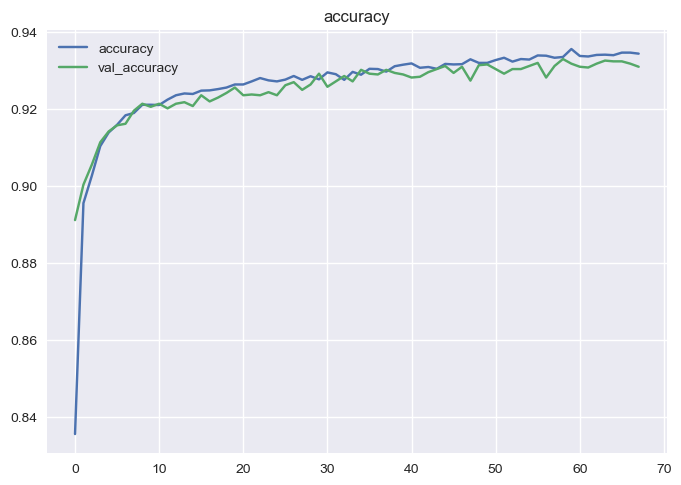

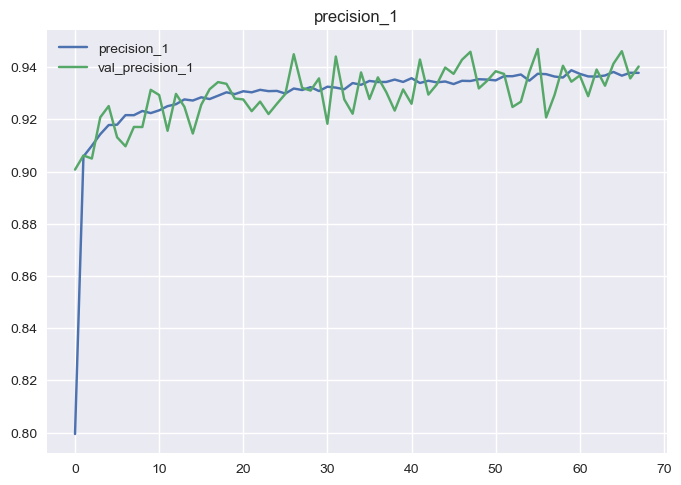

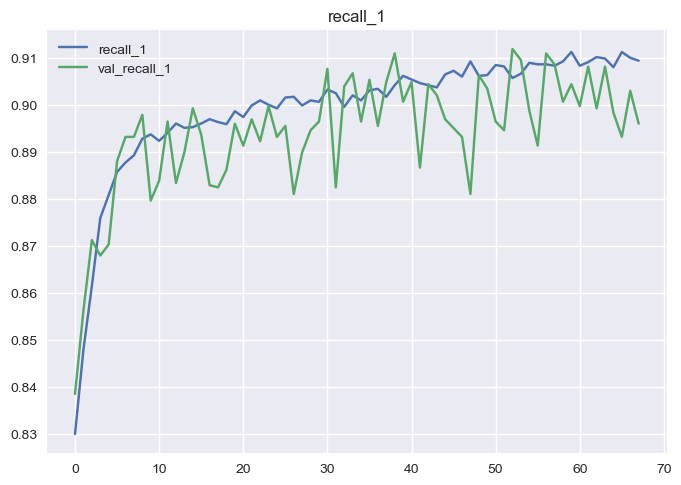

In [ ]:
#create model architecture
input_shape = X_train.shape[1]
class_model2 = Sequential()

#Hidden layers
class_model2.add(Dense(input_shape, input_dim=input_shape, activation='relu'))
class_model2.add(Dense(input_shape * 0.5, activation='relu'))
#Output layer
class_model2.add(Dense(1, activation='sigmoid'))
#compile model with additional metrics
class_model2.compile(loss='bce', optimizer='adam', metrics=['accuracy',
                                                         metrics.Precision(),
                                                         metrics.Recall()])
early_stopping = EarlyStopping(patience = 5)
history2 = class_model2.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs=100,
                        callbacks=[early_stopping],
                        verbose=0)
# plot learning
plot_history(history2)

157/157 [==============================] - 0s 825us/step
base_class_model2_train 

              precision    recall  f1-score   support

 Unsatisfied       0.94      0.95      0.94      8482
   Satisfied       0.93      0.92      0.92      6518

    accuracy                           0.94     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.94      0.93     15000



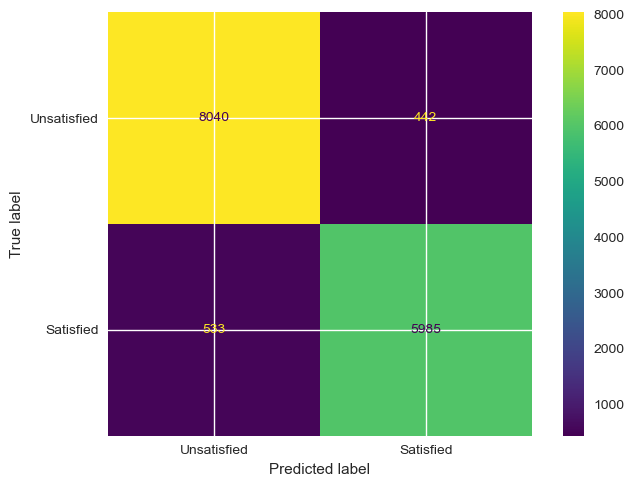

base_class_model2_test 

              precision    recall  f1-score   support

 Unsatisfied       0.93      0.94      0.93      2857
   Satisfied       0.92      0.91      0.91      2143

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



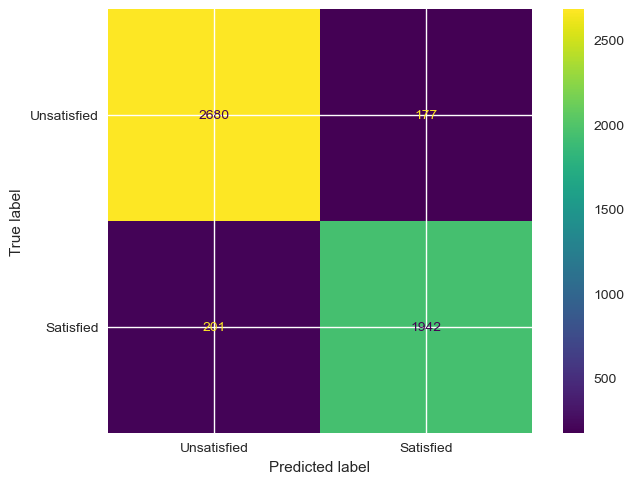

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
base_class_model2_train,0.931228,0.918226,0.924681,0.9350
base_class_model2_test,0.916470,0.906206,0.911309,0.9244


In [ ]:
# Get predictions
model2_train_pred = class_model1.predict(X_train)
model2_test_pred = class_model1.predict(X_test)

# round predictions to integers instead of floats using np.rint()
model2_train_preds = np.rint(model1_train_pred )
model2_test_preds = np.rint(model1_test_pred )

# Define labels for the confusion matrix
labels = ['Unsatisfied', 'Satisfied']
train_scores = eval_classification(y_train, model2_train_preds, 
                                   name='base_class_model2_train',
                                  labels=labels)
test_scores = eval_classification(y_test, model2_test_preds, 
                                   name='base_class_model2_test',
                                  labels=labels)
class_scores = pd.concat([train_scores, test_scores])
class_scores

###Model 3

Same components as model 2 but change regularization from early stopping to dropout 

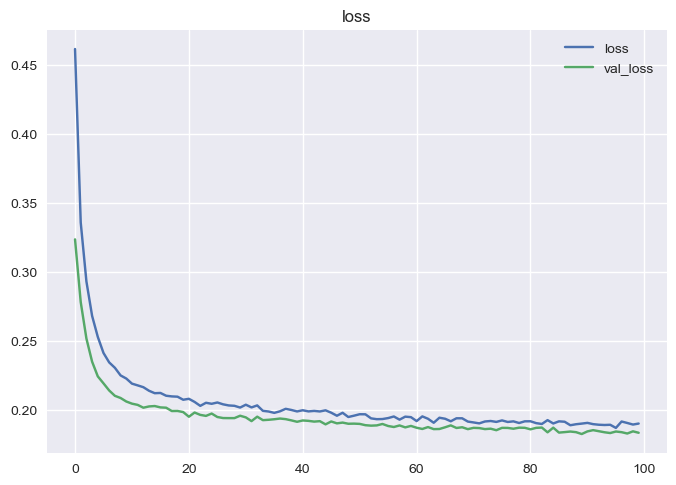

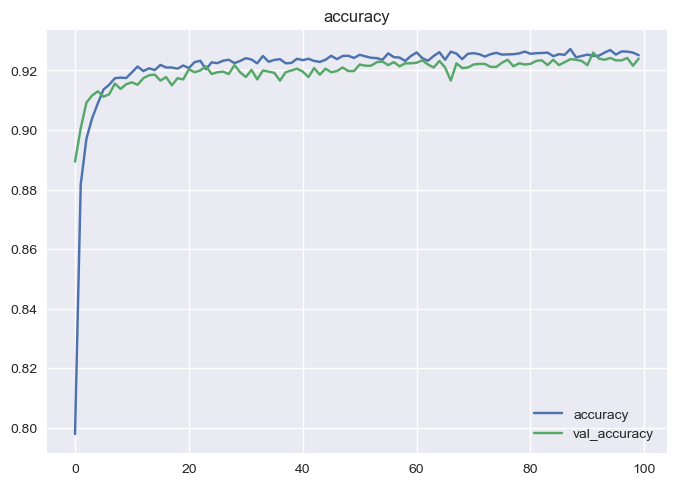

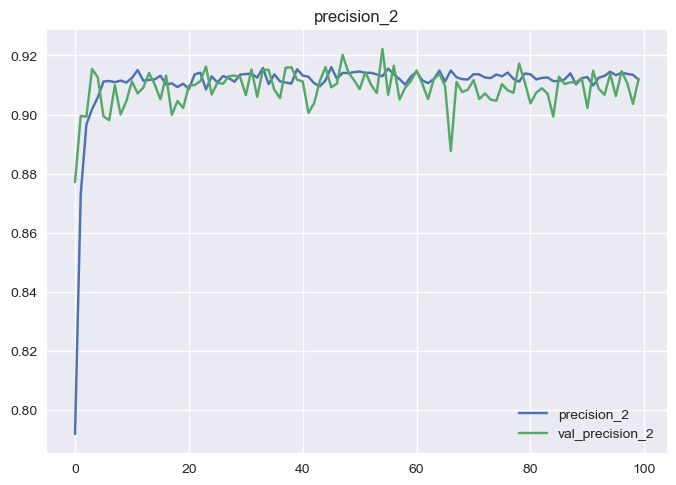

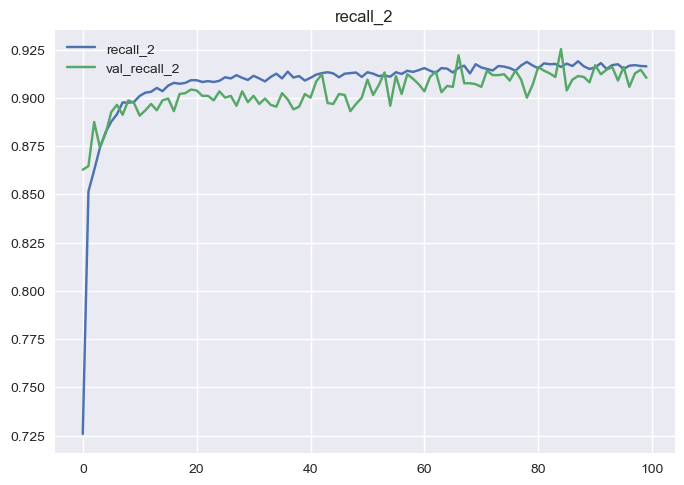

In [ ]:
#create model architecture
input_shape = X_train.shape[1]
 
class_model3 = Sequential()

#Hidden layers
class_model3.add(Dense(input_shape, input_dim=input_shape, activation='relu'))
class_model3.add(Dense(input_shape * 0.5, activation='relu'))
#Dropout layer
class_model3.add(Dropout(0.2))
#Output layer
class_model3.add(Dense(1, activation='sigmoid'))
#compile model with additional metrics
class_model3.compile(loss='bce', optimizer='adam', metrics=['accuracy',
                                                         metrics.Precision(),
                                                         metrics.Recall()])
history3 = class_model3.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs=100,
                        verbose=0)
# plot learning
plot_history(history3)

157/157 [==============================] - 0s 857us/step
base_class_model3_train 

              precision    recall  f1-score   support

 Unsatisfied       0.93      0.94      0.94      8482
   Satisfied       0.92      0.91      0.92      6518

    accuracy                           0.93     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.93      0.93     15000



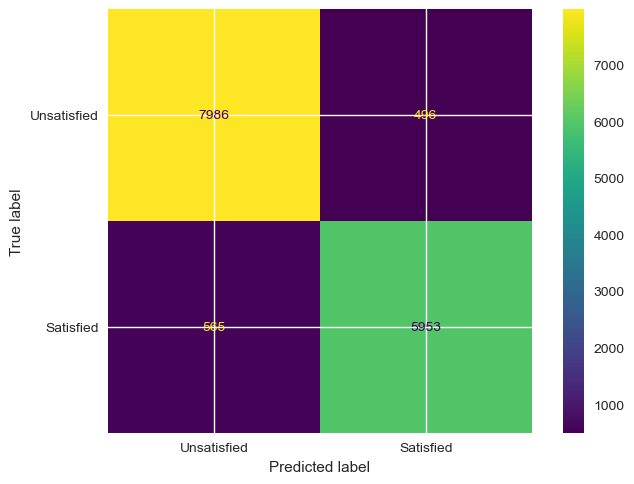

base_class_model3_test 

              precision    recall  f1-score   support

 Unsatisfied       0.93      0.93      0.93      2857
   Satisfied       0.91      0.91      0.91      2143

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



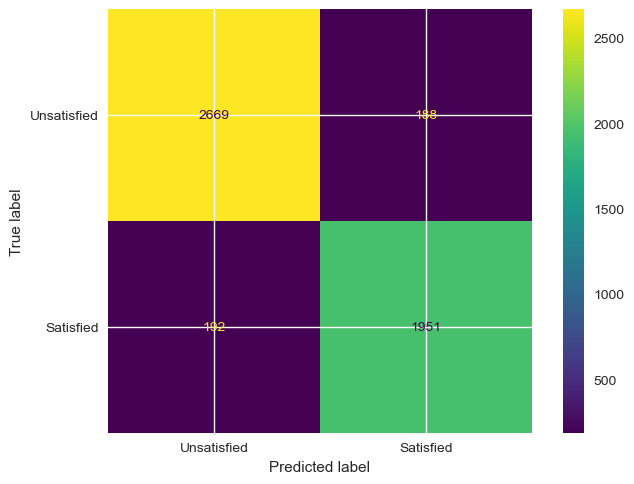

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
base_class_model3_train,0.923089,0.913317,0.918177,0.929267
base_class_model3_test,0.912108,0.910406,0.911256,0.924000


In [ ]:
# Get predictions
model3_train_pred = class_model3.predict(X_train)
model3_test_pred = class_model3.predict(X_test)

# round predictions to integers instead of floats using np.rint()
model3_train_preds = np.rint(model3_train_pred )
model3_test_preds = np.rint(model3_test_pred )

# Define labels for the confusion matrix
labels = ['Unsatisfied', 'Satisfied']
train_scores = eval_classification(y_train, model3_train_preds, 
                                   name='base_class_model3_train',
                                  labels=labels)
test_scores = eval_classification(y_test, model3_test_preds, 
                                   name='base_class_model3_test',
                                  labels=labels)
class_scores = pd.concat([train_scores, test_scores])
class_scores

###Model 4

is composed of Model 2 with one more layer

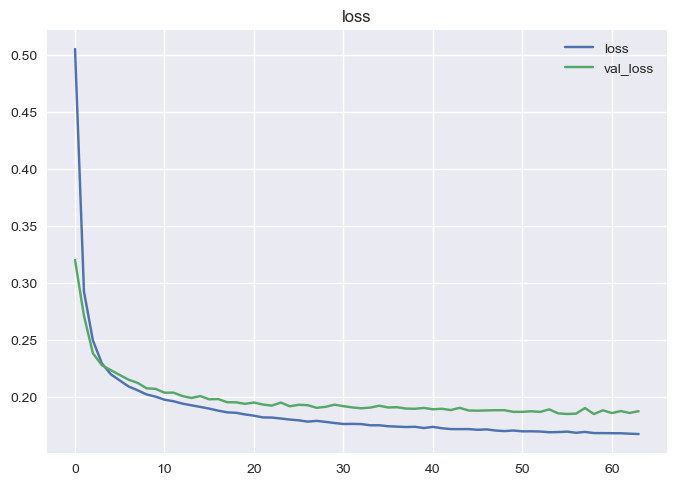

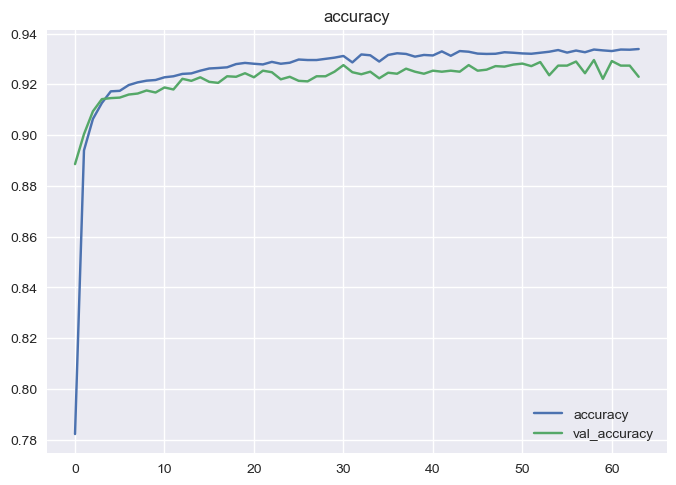

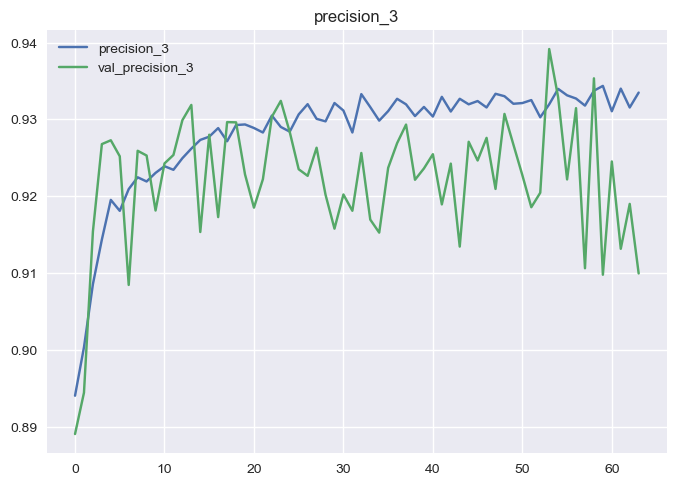

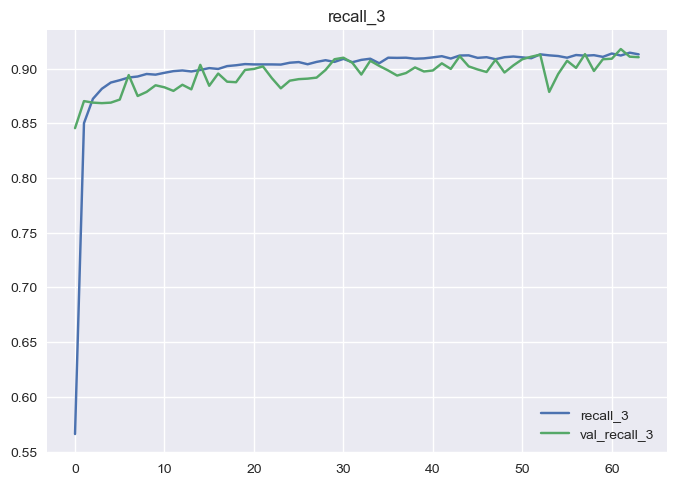

In [ ]:
#create model architecture
input_shape = X_train.shape[1]
 
class_model4 = Sequential()

#Hidden layers
class_model4.add(Dense(input_shape, input_dim=input_shape, activation='relu'))
class_model4.add(Dense(input_shape * 0.5, activation='relu'))
class_model4.add(Dense(input_shape * 0.25, activation='relu'))
#Output layer
class_model4.add(Dense(1, activation='sigmoid'))
#compile model with additional metrics
class_model4.compile(loss='bce', optimizer='adam', metrics=['accuracy',
                                                         metrics.Precision(),
                                                         metrics.Recall()])
early_stopping = EarlyStopping(patience = 5)
history4 = class_model4.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs=100,
                        callbacks=[early_stopping],
                        verbose=0)
# plot learning
plot_history(history4)

157/157 [==============================] - 0s 865us/step
base_class_model4_train 

              precision    recall  f1-score   support

 Unsatisfied       0.94      0.94      0.94      8482
   Satisfied       0.92      0.93      0.92      6518

    accuracy                           0.93     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.93      0.93     15000



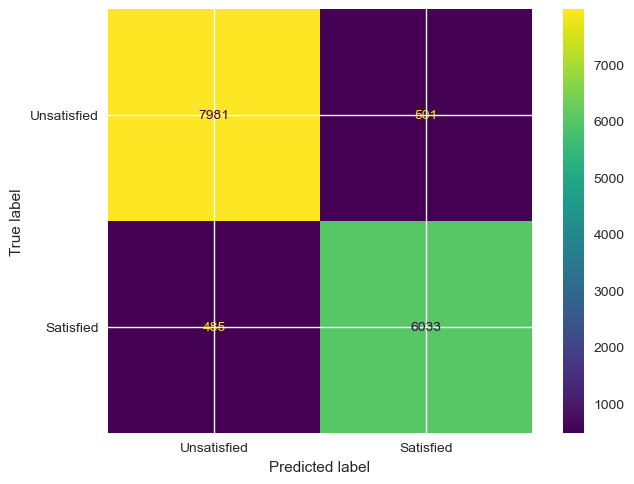

base_class_model4_test 

              precision    recall  f1-score   support

 Unsatisfied       0.93      0.93      0.93      2857
   Satisfied       0.91      0.91      0.91      2143

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



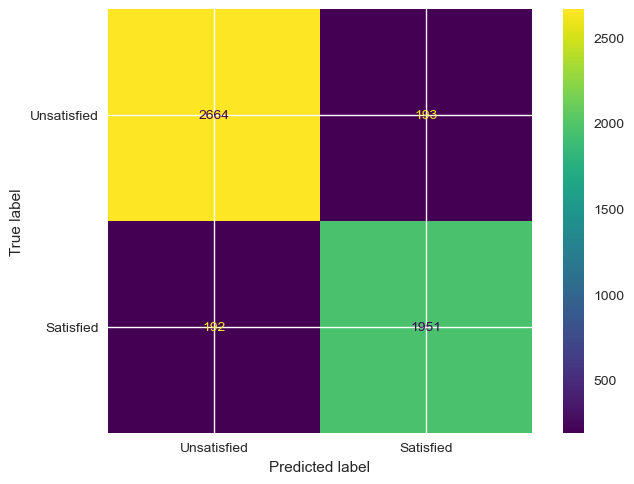

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
base_class_model4_train,0.923324,0.925591,0.924456,0.934267
base_class_model4_test,0.909981,0.910406,0.910194,0.923000


In [ ]:
# Get predictions
model4_train_pred = class_model4.predict(X_train)
model4_test_pred = class_model4.predict(X_test)

# round predictions to integers instead of floats using np.rint()
model4_train_preds = np.rint(model4_train_pred )
model4_test_preds = np.rint(model4_test_pred )

# Define labels for the confusion matrix
labels = ['Unsatisfied', 'Satisfied']
train_scores = eval_classification(y_train, model4_train_preds, 
                                   name='base_class_model4_train',
                                  labels=labels)
test_scores = eval_classification(y_test, model4_test_preds, 
                                   name='base_class_model4_test',
                                  labels=labels)
class_scores = pd.concat([train_scores, test_scores])
class_scores